# Load packages

In [1]:
# plot style
import matplotlib.pyplot as plt
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(theme='gruvboxd')
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')
jtplot.style(ticks=True, grid=False, figsize=(6.5, 5))

In [2]:
import random
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Load Data

In [3]:
date_cols = ['reg_mon','auditing_date','due_date']#,'repay_date']
train_xy = pd.read_csv("../data_preprocess/train_set_nobehavior.csv",parse_dates = date_cols)

train_xy.loc[:,date_cols] = train_xy[date_cols].apply(lambda s: [t.timestamp() for t in s] )

In [4]:
train_xy['repay_amt'].fillna(0,inplace=True)
train_xy['repay_date_delta'].fillna(40,inplace=True)
train_xy[['repay_date','repay_amt','repay_date_delta','y']].head()

,repay_date,repay_amt,repay_date_delta,y
0,2019-01-11,634.1695,25.0,0
1,2018-11-04,927.0431,30.0,0
2,2018-07-06,509.3960,30.0,0
3,2019-01-08,634.1695,31.0,0
4,2018-02-11,1013.0686,28.0,0


In [5]:
X = train_xy.drop(['repay_date','repay_amt','y','repay_date_delta'],axis=1)
y = train_xy["repay_date_delta"]

label = train_xy['y']

In [6]:
train_x,test_x,train_y,test_y = train_test_split(X,y,test_size = 0.3,stratify=label)

In [7]:
dtrain = xgb.DMatrix(train_x,label=train_y)
dtest = xgb.DMatrix(test_x)

F:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [8]:
# params={
#     	'booster':'gbtree',
#     	'objective': 'rank:pairwise',
#     	'scale_pos_weight': float(len(train_y)-sum(train_y))/float(sum(train_y)),
#         'eval_metric': 'auc',
#     	'gamma':0.1,
#     	'max_depth':6,
#     	'lambda':500,
#         'subsample':0.6,
#         'colsample_bytree':0.3,
#         'min_child_weight':0.2, 
#         'eta': 0.04,
#     	'seed':1024,
#     	'nthread':8        }
# xgb_cv = xgb.cv(params,dtrain,num_boost_round=1100,nfold=10,stratified=True,metrics='auc') #return metrics_df
# xgb_model = xgb.train(params,dtrain,num_boost_round=700)

# Define feature select function by xgb

In [9]:
def xgb_feature_select(iter_n,booster='gbtree'):
    # set params range
    random_seed = list(range(10000,20000,100))
    gamma = [i/1000.0 for i in range(0,300,3)]
    max_depth = [5,6,7]
    alpha = list(range(200,300,1))
    lambd = list(range(300,500,2))
    subsample = [i/1000.0 for i in range(500,700,2)]
    colsample_bytree = [i/1000.0 for i in range(550,750,4)]
    min_child_weight = [i/1000.0 for i in range(250,1500,4)]
    
    
    random.shuffle(random_seed)
    random.shuffle(gamma)
    random.shuffle(max_depth)
    random.shuffle(alpha)
    random.shuffle(lambd)
    random.shuffle(subsample)
    random.shuffle(colsample_bytree)
    random.shuffle(min_child_weight)
    
    feature_score_df = pd.DataFrame()
    params_df = pd.DataFrame()
    evals_df = pd.DataFrame()
    loop = 1
    for i in range(iter_n):
        params={
            'booster':booster,
#             'objective': 'rank:pairwise',
            'objective':'reg:squarederror',
#             'scale_pos_weight': float(len(train_y)-sum(train_y))/float(sum(train_y)),
            'eval_metric': 'rmse',
            'gamma':gamma[i],
            'max_depth':max_depth[i%3],
            'alpha':alpha[i],
            'lambda':lambd[i],
            'subsample':subsample[i],
            'colsample_bytree':colsample_bytree[i],
            'min_child_weight':min_child_weight[i], 
            'eta': 0.02,
            'seed':random_seed[i],
            'silent':1,
            'missing':-1,
        }
        
        print("---------------------loop %s-------------------------------" % loop)
        evals_result = {} #形如 {'train':{'rmse':[32,43,43]}}
        xgb_model = xgb.train(params,dtrain,num_boost_round=1000,evals_result = evals_result,
                              early_stopping_rounds=600,evals=[(dtrain,"train")],verbose_eval=10)
    
        #save feature score to df
        feature_score = pd.Series(xgb_model.get_fscore())
        feature_score_df = pd.concat([feature_score_df,feature_score],axis=1)
        
        # save params to df
        params_df = pd.concat([params_df,pd.Series(params,name="%i" % i)],axis=1)
        
        # save evals to df
        evals_best = pd.DataFrame([kv.get('rmse')[-1] for k,kv in evals_result.items()],index=['rmse'])
        evals_df = pd.concat([evals_df,evals_best],axis=1)
        
        loop+=1
        
    feature_score_sum = feature_score_df.fillna(0).sum(axis=1).sort_values(ascending=False)
    feature_score_sum.index.name = "features"
    feature_score_sum.name = "scores_sum"
    feature_score_sum.to_excel("./feature_score_xgb.xlsx" )
    
    params_df.to_excel("./params_xgb.xlsx")
    
    evals_df.to_excel("./evals_df.xlsx")
    
    #plot feature importance
    plt.figure(figsize=(10,10))
    xgb.plot_importance(feature_score_sum[:25].to_dict())
    plt.grid(False)
    return plt

---------------------loop 1-------------------------------
[0]	train-rmse:28.1027
Will train until train-rmse hasn't improved in 600 rounds.
[10]	train-rmse:23.447
[20]	train-rmse:19.7317
[30]	train-rmse:16.794
[40]	train-rmse:14.5004
[50]	train-rmse:12.7381
[60]	train-rmse:11.407
[70]	train-rmse:10.42
[80]	train-rmse:9.70276
[90]	train-rmse:9.18948
[100]	train-rmse:8.82661
[110]	train-rmse:8.57306
[120]	train-rmse:8.39739
[130]	train-rmse:8.2764
[140]	train-rmse:8.19286
[150]	train-rmse:8.13512
[160]	train-rmse:8.09481
[170]	train-rmse:8.06648
[180]	train-rmse:8.04615
[190]	train-rmse:8.03193
[200]	train-rmse:8.0215
[210]	train-rmse:8.01389
[220]	train-rmse:8.00795
[230]	train-rmse:8.00315
[240]	train-rmse:7.99972
[250]	train-rmse:7.99659
[260]	train-rmse:7.99419
[270]	train-rmse:7.99208
[280]	train-rmse:7.99013
[290]	train-rmse:7.98853
[300]	train-rmse:7.98712
[310]	train-rmse:7.98579
[320]	train-rmse:7.98468
[330]	train-rmse:7.9834
[340]	train-rmse:7.98215
[350]	train-rmse:7.98093
[

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



---------------------loop 2-------------------------------
[0]	train-rmse:28.1028
Will train until train-rmse hasn't improved in 600 rounds.
[10]	train-rmse:23.4487
[20]	train-rmse:19.7353
[30]	train-rmse:16.7981
[40]	train-rmse:14.506
[50]	train-rmse:12.7438
[60]	train-rmse:11.4129
[70]	train-rmse:10.4262
[80]	train-rmse:9.70801
[90]	train-rmse:9.19406
[100]	train-rmse:8.83188
[110]	train-rmse:8.57905
[120]	train-rmse:8.40343
[130]	train-rmse:8.28211
[140]	train-rmse:8.19894
[150]	train-rmse:8.14131
[160]	train-rmse:8.1014
[170]	train-rmse:8.07366
[180]	train-rmse:8.05409
[190]	train-rmse:8.04016
[200]	train-rmse:8.02993
[210]	train-rmse:8.02262
[220]	train-rmse:8.01669
[230]	train-rmse:8.01226
[240]	train-rmse:8.00872
[250]	train-rmse:8.00596
[260]	train-rmse:8.00351
[270]	train-rmse:8.00174
[280]	train-rmse:7.99962
[290]	train-rmse:7.99789
[300]	train-rmse:7.99636
[310]	train-rmse:7.99527
[320]	train-rmse:7.99432
[330]	train-rmse:7.99321
[340]	train-rmse:7.99206
[350]	train-rmse:7.9

[90]	train-rmse:9.19295
[100]	train-rmse:8.83106
[110]	train-rmse:8.57795
[120]	train-rmse:8.40295
[130]	train-rmse:8.28235
[140]	train-rmse:8.19908
[150]	train-rmse:8.14141
[160]	train-rmse:8.10144
[170]	train-rmse:8.07344
[180]	train-rmse:8.05353
[190]	train-rmse:8.03976
[200]	train-rmse:8.02967
[210]	train-rmse:8.02234
[220]	train-rmse:8.01659
[230]	train-rmse:8.01217
[240]	train-rmse:8.00881
[250]	train-rmse:8.00586
[260]	train-rmse:8.00365
[270]	train-rmse:8.00121
[280]	train-rmse:7.99932
[290]	train-rmse:7.99773
[300]	train-rmse:7.99639
[310]	train-rmse:7.99498
[320]	train-rmse:7.99372
[330]	train-rmse:7.99253
[340]	train-rmse:7.99132
[350]	train-rmse:7.99042
[360]	train-rmse:7.98947
[370]	train-rmse:7.98852
[380]	train-rmse:7.98763
[390]	train-rmse:7.98661
[400]	train-rmse:7.98578
[410]	train-rmse:7.98488
[420]	train-rmse:7.98407
[430]	train-rmse:7.98332
[440]	train-rmse:7.98247
[450]	train-rmse:7.98183
[460]	train-rmse:7.98117
[470]	train-rmse:7.98043
[480]	train-rmse:7.97978
[

[220]	train-rmse:8.01376
[230]	train-rmse:8.00949
[240]	train-rmse:8.0062
[250]	train-rmse:8.00348
[260]	train-rmse:8.00145
[270]	train-rmse:7.99931
[280]	train-rmse:7.99733
[290]	train-rmse:7.99574
[300]	train-rmse:7.99446
[310]	train-rmse:7.9932
[320]	train-rmse:7.99199
[330]	train-rmse:7.99072
[340]	train-rmse:7.98964
[350]	train-rmse:7.98871
[360]	train-rmse:7.98746
[370]	train-rmse:7.98655
[380]	train-rmse:7.98568
[390]	train-rmse:7.98496
[400]	train-rmse:7.98406
[410]	train-rmse:7.98338
[420]	train-rmse:7.98266
[430]	train-rmse:7.98193
[440]	train-rmse:7.98125
[450]	train-rmse:7.98057
[460]	train-rmse:7.97988
[470]	train-rmse:7.97917
[480]	train-rmse:7.97841
[490]	train-rmse:7.97773
[500]	train-rmse:7.97707
[510]	train-rmse:7.97638
[520]	train-rmse:7.97578
[530]	train-rmse:7.97508
[540]	train-rmse:7.97456
[550]	train-rmse:7.97394
[560]	train-rmse:7.97344
[570]	train-rmse:7.97282
[580]	train-rmse:7.97229
[590]	train-rmse:7.97177
[600]	train-rmse:7.97119
[610]	train-rmse:7.9707
[62

[350]	train-rmse:7.98953
[360]	train-rmse:7.98846
[370]	train-rmse:7.98712
[380]	train-rmse:7.98617
[390]	train-rmse:7.98522
[400]	train-rmse:7.98417
[410]	train-rmse:7.98338
[420]	train-rmse:7.98255
[430]	train-rmse:7.98173
[440]	train-rmse:7.98106
[450]	train-rmse:7.98017
[460]	train-rmse:7.97948
[470]	train-rmse:7.97878
[480]	train-rmse:7.97805
[490]	train-rmse:7.9773
[500]	train-rmse:7.97673
[510]	train-rmse:7.97612
[520]	train-rmse:7.97546
[530]	train-rmse:7.97494
[540]	train-rmse:7.97428
[550]	train-rmse:7.97368
[560]	train-rmse:7.97301
[570]	train-rmse:7.97247
[580]	train-rmse:7.97193
[590]	train-rmse:7.97129
[600]	train-rmse:7.97068
[610]	train-rmse:7.97013
[620]	train-rmse:7.96964
[630]	train-rmse:7.96909
[640]	train-rmse:7.96859
[650]	train-rmse:7.96806
[660]	train-rmse:7.96748
[670]	train-rmse:7.96703
[680]	train-rmse:7.96654
[690]	train-rmse:7.96615
[700]	train-rmse:7.96566
[710]	train-rmse:7.96528
[720]	train-rmse:7.96477
[730]	train-rmse:7.96424
[740]	train-rmse:7.9638
[7

[490]	train-rmse:7.97634
[500]	train-rmse:7.97578
[510]	train-rmse:7.9752
[520]	train-rmse:7.97463
[530]	train-rmse:7.97396
[540]	train-rmse:7.97345
[550]	train-rmse:7.97288
[560]	train-rmse:7.97232
[570]	train-rmse:7.9718
[580]	train-rmse:7.97119
[590]	train-rmse:7.9706
[600]	train-rmse:7.97014
[610]	train-rmse:7.96966
[620]	train-rmse:7.96903
[630]	train-rmse:7.96859
[640]	train-rmse:7.96809
[650]	train-rmse:7.96757
[660]	train-rmse:7.96707
[670]	train-rmse:7.96656
[680]	train-rmse:7.96605
[690]	train-rmse:7.96557
[700]	train-rmse:7.96513
[710]	train-rmse:7.96462
[720]	train-rmse:7.96422
[730]	train-rmse:7.96372
[740]	train-rmse:7.96317
[750]	train-rmse:7.96278
[760]	train-rmse:7.96232
[770]	train-rmse:7.96196
[780]	train-rmse:7.96153
[790]	train-rmse:7.96108
[800]	train-rmse:7.96068
[810]	train-rmse:7.96031
[820]	train-rmse:7.95987
[830]	train-rmse:7.95937
[840]	train-rmse:7.95903
[850]	train-rmse:7.95868
[860]	train-rmse:7.95828
[870]	train-rmse:7.9579
[880]	train-rmse:7.95747
[890

[620]	train-rmse:7.97158
[630]	train-rmse:7.97107
[640]	train-rmse:7.97063
[650]	train-rmse:7.97002
[660]	train-rmse:7.96953
[670]	train-rmse:7.96909
[680]	train-rmse:7.96857
[690]	train-rmse:7.96804
[700]	train-rmse:7.96754
[710]	train-rmse:7.9671
[720]	train-rmse:7.96674
[730]	train-rmse:7.96626
[740]	train-rmse:7.96579
[750]	train-rmse:7.96532
[760]	train-rmse:7.96496
[770]	train-rmse:7.96458
[780]	train-rmse:7.96418
[790]	train-rmse:7.96378
[800]	train-rmse:7.96336
[810]	train-rmse:7.96301
[820]	train-rmse:7.96265
[830]	train-rmse:7.96226
[840]	train-rmse:7.96183
[850]	train-rmse:7.96147
[860]	train-rmse:7.96103
[870]	train-rmse:7.9607
[880]	train-rmse:7.96034
[890]	train-rmse:7.95999
[900]	train-rmse:7.95965
[910]	train-rmse:7.9593
[920]	train-rmse:7.9589
[930]	train-rmse:7.95849
[940]	train-rmse:7.95813
[950]	train-rmse:7.95785
[960]	train-rmse:7.95746
[970]	train-rmse:7.95711
[980]	train-rmse:7.95682
[990]	train-rmse:7.95652
[999]	train-rmse:7.95627
---------------------loop 18-

[750]	train-rmse:7.96429
[760]	train-rmse:7.96386
[770]	train-rmse:7.96345
[780]	train-rmse:7.96307
[790]	train-rmse:7.96268
[800]	train-rmse:7.96227
[810]	train-rmse:7.9619
[820]	train-rmse:7.96143
[830]	train-rmse:7.961
[840]	train-rmse:7.96064
[850]	train-rmse:7.96024
[860]	train-rmse:7.95985
[870]	train-rmse:7.95953
[880]	train-rmse:7.95913
[890]	train-rmse:7.95878
[900]	train-rmse:7.95839
[910]	train-rmse:7.95804
[920]	train-rmse:7.95768
[930]	train-rmse:7.95733
[940]	train-rmse:7.957
[950]	train-rmse:7.95666
[960]	train-rmse:7.95632
[970]	train-rmse:7.95599
[980]	train-rmse:7.95569
[990]	train-rmse:7.95538
[999]	train-rmse:7.95505
---------------------loop 21-------------------------------
[0]	train-rmse:28.1023
Will train until train-rmse hasn't improved in 600 rounds.
[10]	train-rmse:23.4442
[20]	train-rmse:19.7271
[30]	train-rmse:16.7882
[40]	train-rmse:14.4945
[50]	train-rmse:12.7316
[60]	train-rmse:11.4015
[70]	train-rmse:10.4154
[80]	train-rmse:9.69766
[90]	train-rmse:9.184

[880]	train-rmse:7.95994
[890]	train-rmse:7.9596
[900]	train-rmse:7.95923
[910]	train-rmse:7.95885
[920]	train-rmse:7.95849
[930]	train-rmse:7.95816
[940]	train-rmse:7.95782
[950]	train-rmse:7.95747
[960]	train-rmse:7.95711
[970]	train-rmse:7.95674
[980]	train-rmse:7.95643
[990]	train-rmse:7.9561
[999]	train-rmse:7.95582
---------------------loop 24-------------------------------
[0]	train-rmse:28.1031
Will train until train-rmse hasn't improved in 600 rounds.
[10]	train-rmse:23.4485
[20]	train-rmse:19.733
[30]	train-rmse:16.7962
[40]	train-rmse:14.504
[50]	train-rmse:12.7417
[60]	train-rmse:11.4112
[70]	train-rmse:10.4257
[80]	train-rmse:9.70791
[90]	train-rmse:9.19404
[100]	train-rmse:8.83118
[110]	train-rmse:8.57731
[120]	train-rmse:8.40154
[130]	train-rmse:8.27943
[140]	train-rmse:8.19445
[150]	train-rmse:8.13584
[160]	train-rmse:8.09477
[170]	train-rmse:8.06583
[180]	train-rmse:8.04474
[190]	train-rmse:8.02973
[200]	train-rmse:8.01943
[210]	train-rmse:8.01085
[220]	train-rmse:8.00

[0]	train-rmse:28.1029
Will train until train-rmse hasn't improved in 600 rounds.
[10]	train-rmse:23.4466
[20]	train-rmse:19.7304
[30]	train-rmse:16.7937
[40]	train-rmse:14.5007
[50]	train-rmse:12.7387
[60]	train-rmse:11.4084
[70]	train-rmse:10.4226
[80]	train-rmse:9.70438
[90]	train-rmse:9.19076
[100]	train-rmse:8.82782
[110]	train-rmse:8.57517
[120]	train-rmse:8.39925
[130]	train-rmse:8.27728
[140]	train-rmse:8.19332
[150]	train-rmse:8.13569
[160]	train-rmse:8.09512
[170]	train-rmse:8.06674
[180]	train-rmse:8.04574
[190]	train-rmse:8.03113
[200]	train-rmse:8.01975
[210]	train-rmse:8.01133
[220]	train-rmse:8.00536
[230]	train-rmse:8.0003
[240]	train-rmse:7.99653
[250]	train-rmse:7.99338
[260]	train-rmse:7.99038
[270]	train-rmse:7.98779
[280]	train-rmse:7.9854
[290]	train-rmse:7.98351
[300]	train-rmse:7.98191
[310]	train-rmse:7.98031
[320]	train-rmse:7.9788
[330]	train-rmse:7.9773
[340]	train-rmse:7.9757
[350]	train-rmse:7.97433
[360]	train-rmse:7.97299
[370]	train-rmse:7.97203
[380]	t

[120]	train-rmse:8.39438
[130]	train-rmse:8.27307
[140]	train-rmse:8.18951
[150]	train-rmse:8.1315
[160]	train-rmse:8.09112
[170]	train-rmse:8.06234
[180]	train-rmse:8.04127
[190]	train-rmse:8.02665
[200]	train-rmse:8.01613
[210]	train-rmse:8.00828
[220]	train-rmse:8.00193
[230]	train-rmse:7.99702
[240]	train-rmse:7.99294
[250]	train-rmse:7.98985
[260]	train-rmse:7.98734
[270]	train-rmse:7.98489
[280]	train-rmse:7.98304
[290]	train-rmse:7.98132
[300]	train-rmse:7.97959
[310]	train-rmse:7.97781
[320]	train-rmse:7.97616
[330]	train-rmse:7.97452
[340]	train-rmse:7.97283
[350]	train-rmse:7.97127
[360]	train-rmse:7.96968
[370]	train-rmse:7.96854
[380]	train-rmse:7.96731
[390]	train-rmse:7.96628
[400]	train-rmse:7.96512
[410]	train-rmse:7.96417
[420]	train-rmse:7.96297
[430]	train-rmse:7.96183
[440]	train-rmse:7.96075
[450]	train-rmse:7.95961
[460]	train-rmse:7.95839
[470]	train-rmse:7.95758
[480]	train-rmse:7.95669
[490]	train-rmse:7.95572
[500]	train-rmse:7.95483
[510]	train-rmse:7.95396
[

<module 'matplotlib.pyplot' from 'F:\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<Figure size 720x720 with 0 Axes>

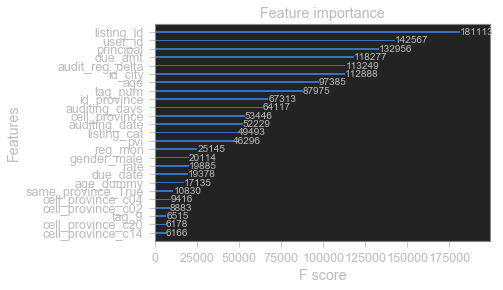

In [10]:
xgb_feature_select(30)

In [11]:
# best params:
# alpha:215 
# booster:gbtree
# colsample_bytree:0.694
# eta:0.02
# eval_metric:rmse
# gamma:0.147
# lambda:440
# max_depth:7
# min_child_weight:0.854
# missing:-1
# objective:reg:squarederror
# seed:19800
# silent:1
# subsample:0.662

# alpha:231
# booster:gbtree
# colsample_bytree:0.73
# eta:0.02
# eval_metric:rmse
# gamma:0.084
# lambda:384
# max_depth:7
# min_child_weight:0.322
# missing:-1
# objective:reg:squarederror
# seed:1980014800
# silent:1
# subsample:0.644


# Define feature select function by trees

In [17]:
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier

In [18]:
def tree_feature_select(iter_n,model='ext'):
    # set params range
    n_estimators = list(range(50,300,5))
    criterion = ["gini","entropy"]
    max_features = [i/1000.0 for i in range(550,750,4)]
    max_depth = [5,6,7] 
    min_samples_split = [i/1000.0 for i in range(500,700,2)]
    min_weight_fraction_leaf= [i/1000.0 for i in range(500)]
    random_state = list(range(10000,20000,100))
    class_weight = "balanced"
    n_jobs = -1
    
    random.shuffle(n_estimators)
    random.shuffle(criterion)
    random.shuffle(max_features)
    random.shuffle(max_depth)
    random.shuffle(min_samples_split)
    random.shuffle(min_weight_fraction_leaf)
    random.shuffle(random_state)
    
    feature_score_df = pd.DataFrame()
    params_df = pd.DataFrame()
    for i in range(iter_n):
        params = {
            'n_estimators':n_estimators[i],
            'criterion':criterion[i%2],
            'max_features':max_features[i],
            'max_depth':max_depth[i%3],
            'min_samples_split':min_samples_split[i],
            'min_weight_fraction_leaf':min_weight_fraction_leaf[i],
            'random_state':random_state[i],
            'class_weight':class_weight,
            'n_jobs':n_jobs
        }
        if model=='ext':
            ext_model = ExtraTreesClassifier().set_params(**params)
            ext_model.fit(train_x,train_y)
    
            #save feature score to df
            feature_score = pd.Series(ext_model.feature_importances_,index=train_x.columns)
        elif model=='rf':
            rf_model = RandomForestClassifier().set_params(**params)
            rf_model.fit(train_x,train_y)
    
            #save feature score to df
            feature_score = pd.Series(rf_model.feature_importances_,index=train_x.columns)
        
        feature_score_df = pd.concat([feature_score_df,feature_score],axis=1)
        # save params to df
        params_df = pd.concat([params_df,pd.Series(params,name="%i" % i)],axis=1)
        
    
    feature_score_sum = feature_score_df.fillna(0).sum(axis=1).sort_values(ascending=False).round(4)
    feature_score_sum.index.name = "features"
    feature_score_sum.name = "scores_sum"
    feature_score_sum.to_excel("./feature_select/feature_score_trees_%s.xlsx" % model)
    params_df.to_excel("./feature_select/params_trees_%s.xlsx" % model)
    #plot feature importance
    sort_idx = np.argsort(feature_score_sum[:20])
    plt.figure(figsize=(10,10))
    plt.barh(range(len(sort_idx)),feature_score_sum[sort_idx], align='center')
    plt.yticks(range(len(sort_idx)), feature_score_sum.index[sort_idx])
    plt.title('feature importance')

    return plt

<module 'matplotlib.pyplot' from 'F:\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

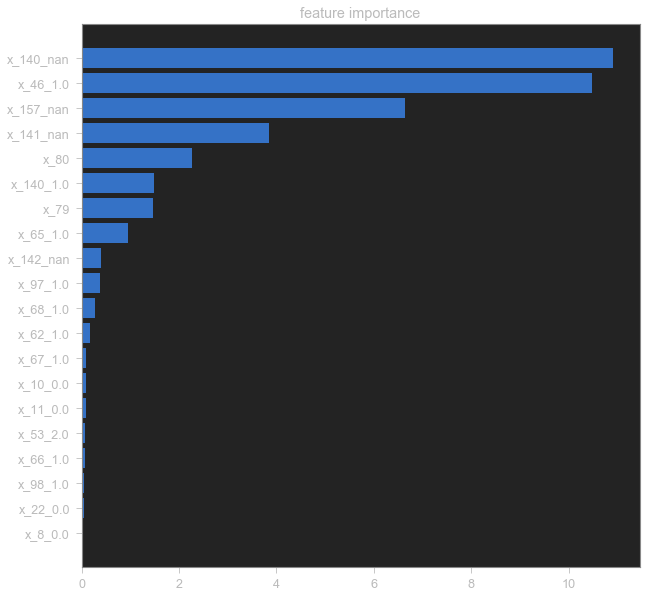

In [20]:
train_x = train_x.fillna(-1)
train_y = train_y.fillna(-1)
tree_feature_select(40)

<module 'matplotlib.pyplot' from 'F:\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

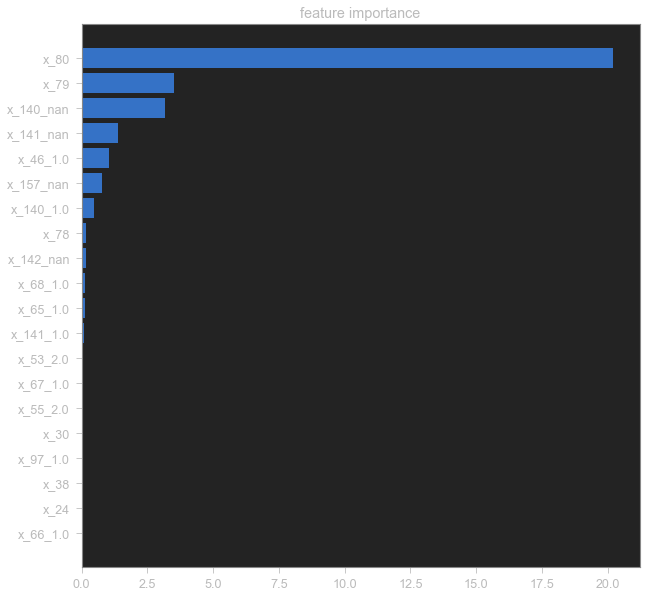

In [21]:
tree_feature_select(40,model='rf')

Text(0.5,1,'feature importance')

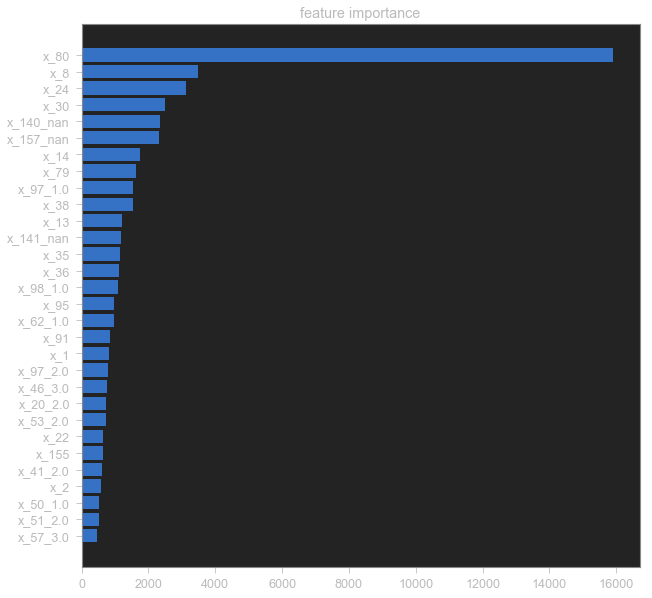

In [22]:
xgb_feature_score = pd.read_excel("./feature_select/feature_score_xgb_gbtree.xlsx",index_col="features")
trees_feature_ext = pd.read_excel("./feature_select/feature_score_trees_ext.xlsx",index_col="features")
trees_feature_rf = pd.read_excel("./feature_select/feature_score_trees_rf.xlsx",index_col="features")
feature_scores_total = pd.concat([xgb_feature_score,trees_feature_ext,trees_feature_rf],axis=1).fillna(0).sum(axis=1).sort_values(ascending=False)
feature_scores_total.to_excel("./feature_select/feature_scores_total.xlsx")
sort_idx = np.argsort(feature_scores_total[:30])
plt.figure(figsize=(10,10))
plt.barh(range(len(sort_idx)),feature_scores_total[sort_idx], align='center')
plt.yticks(range(len(sort_idx)), feature_scores_total.index[sort_idx])
plt.title('feature importance')

In [23]:
feature_scores_total[feature_scores_total==0].sort_index()

x_100_nan    0.0
x_101_nan    0.0
x_10_2.0     0.0
x_10_3.0     0.0
x_10_4.0     0.0
x_11_1.0     0.0
x_11_2.0     0.0
x_11_3.0     0.0
x_11_4.0     0.0
x_139_nan    0.0
x_13_1.0     0.0
x_140_2.0    0.0
x_141_2.0    0.0
x_141_4.0    0.0
x_142_2.0    0.0
x_143_nan    0.0
x_144_3.0    0.0
x_144_nan    0.0
x_145_1.0    0.0
x_145_2.0    0.0
x_145_nan    0.0
x_147_0.0    0.0
x_147_1.0    0.0
x_147_nan    0.0
x_148_1.0    0.0
x_148_2.0    0.0
x_148_3.0    0.0
x_148_nan    0.0
x_149_1.0    0.0
x_149_3.0    0.0
            ... 
x_86_9.0     0.0
x_86_nan     0.0
x_87_1.0     0.0
x_87_2.0     0.0
x_87_3.0     0.0
x_87_4.0     0.0
x_87_nan     0.0
x_88_1.0     0.0
x_88_10.0    0.0
x_88_2.0     0.0
x_88_3.0     0.0
x_88_4.0     0.0
x_88_5.0     0.0
x_88_6.0     0.0
x_88_7.0     0.0
x_88_8.0     0.0
x_88_9.0     0.0
x_88_nan     0.0
x_89_1.0     0.0
x_89_2.0     0.0
x_89_nan     0.0
x_8_1.0      0.0
x_8_nan      0.0
x_96_nan     0.0
x_97_nan     0.0
x_98_3.0     0.0
x_98_nan     0.0
x_99_nan     0